In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from pathlib import Path

In [2]:
DIR_PATH = Path("..")

In [3]:
seed = 42

# Dataset

### loading

In [4]:
data_inpath = DIR_PATH / "datasets/trx_data.csv"

df = pd.read_csv(data_inpath, sep=',')
df.shape

(28601, 5)

In [5]:
df.head()

,id_seq,sequence,start,end,group
0,tr|F0RTT8|F0RTT8_SPHGB,MSEIIVTEANFEQEVLKADKPVLVDFWAPWCGPCKMIAPAIAQLAQ...,7,83,TRX-1
1,tr|A0A7W0KXH4|A0A7W0KXH4_9ACTN,MAIDVTDATFDEQVILASAQQPVVVDLWAEWCGPCRTLGPIIEKVV...,3,84,TRX-1
2,tr|A0A950RKP2|A0A950RKP2_UNCPL,MSSSQTAPIINVGEEDFERAVIEQSHERPVIVDFWAPWCPPCRMLA...,10,91,TRX-1
3,tr|A0A9E3Y983|A0A9E3Y983_9ACTN,MTMIDVTDQTFEAEVLQKSMEVPVVVDLWAPWCGPCRTLGPILDKV...,4,85,TRX-1
4,tr|A0A1V5RS69|A0A1V5RS69_9CHLR,MKSEYVIDVSDATFQTEVINRSRQTPVVVDFWAPWCGPCRMLGPVL...,6,88,TRX-1


Remove possible gaps

In [6]:
df['sequence'] = df['sequence'].apply(lambda x: x.replace('-',''))

In [7]:
print(f"longer sequence length = {df['sequence'].str.len().max()}")
print(f"shorter sequence length = {df['sequence'].str.len().min()}")

longer sequence length = 8256
shorter sequence length = 97


Remove possible duplicates

In [8]:
n_duplicates = df.duplicated(subset='sequence').sum()
print(f"duplicates = {n_duplicates}")

if n_duplicates > 0:
    df = df.drop_duplicates(subset='sequence')
df.shape

duplicates = 0


(28601, 5)

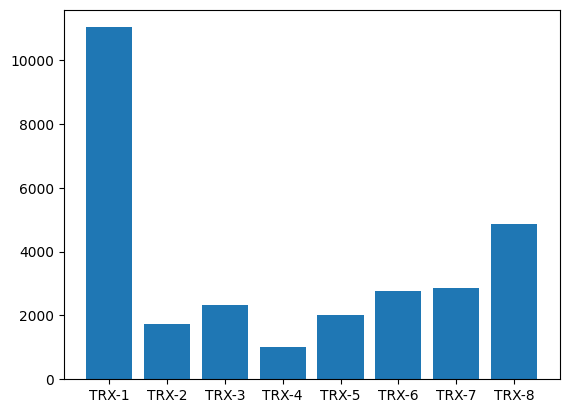

In [9]:
supports = df['group'].value_counts().sort_index(key=lambda x: x.str.extract(r'(\d+)')[0].astype(int))
plt.bar(supports.index, supports)
plt.show()

Splitting 80/10/10

In [10]:
from sklearn.model_selection import train_test_split

indices = df.index
pd_cat = pd.Categorical(df['group'])

labels = pd_cat.categories
df['label'] = pd_cat.codes

train_idx, test_idx = train_test_split(indices, test_size=0.1, random_state=seed, stratify=df['label'])
train_idx, val_idx = train_test_split(train_idx, test_size=0.1/0.9, random_state=seed, stratify=df.iloc[train_idx]['label'])

train_df = df.iloc[train_idx].reset_index(drop=True)
val_df = df.iloc[val_idx].reset_index(drop=True)
test_df = df.iloc[val_idx].reset_index(drop=True)

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(22880, 6)
(2860, 6)
(2860, 6)


### Sequence identity

In [136]:
def sq_identity(s1,s2):

    score = 0
    for i in range(len(s1)):
        
        aa1,aa2 = s1[i],s2[i]

        if aa1 != '-' and aa2 != '-':
            score += aa1 == aa2

    return score / len(s1)

In [146]:
import subprocess
from collections import defaultdict
from Bio import AlignIO

infile = DIR_PATH / ".tmp_inmafft.fasta"
outfile = DIR_PATH / ".tmp_outmafft.fasta"

cli_mafft = f"mafft --localpair --thread 16 --anysymbol {infile} > {outfile}"

classes_idenity_info = defaultdict(defaultdict)

for classes in train_df['group'].unique():

    class_df = train_df[train_df['group'] == classes]
    
    f = open(infile, 'w')
    fasta_str = "".join([f">{id}\n{seq}\n" for id, seq in class_df[['id_seq','sequence']].values])
    f.write(fasta_str)
    f.close()

    print(f"Computing msa for {classes} ...")

    result = subprocess.run(cli_mafft, shell=True, capture_output=True, text=True)
    
    if result.returncode == 0:
        print(f"Successfull msa for {classes}")

        msa = AlignIO.read(outfile, "fasta")
        
        index_val = list()
        col_val = list()

        id_mtx = np.eye(len(msa))

        for index1 in range(len(msa)-1):

            for index2 in range(index1+1, len(msa)):

                if index1 != index2:

                    index_val.append(msa[index1].id)
                    col_val.append(msa[index2].id)
                    
                    id_mtx[index1][index2] = sq_identity(msa[index1].seq, msa[index2].seq)

        classes_idenity_info[classes]['id_mtx'] = pd.DataFrame(id_mtx, index=index_val, columns=col_val)
       
    else:
        print(f"Command for {classes} failed with error: {result.stderr.strip()}")

Computing msa for TRX-1 ...
Successfull msa for TRX-1


KeyboardInterrupt: 

In [12]:
from collections import defaultdict
from Bio import Align
from Bio.Align import substitution_matrices
from concurrent.futures import ThreadPoolExecutor


def compute_score(i, j, s1, s2, aligner):

    
    return (i, j, aligner.score(s1, s2) / len(min(s1, s2, key=len)))


classes_identity_info = defaultdict(defaultdict)

# substitution_matrices.load()  
# matrix = substitution_matrices.load("BLOSUM62")
aligner = Align.PairwiseAligner(match_score=1.0)

# aligner.substitution_matrix = matrix

for label in train_df['label'].unique():
    class_df = train_df[train_df['label'] == label].reset_index(drop=True)
    
    index_val = list()
    col_val = list()
    id_mtx = np.eye(len(class_df))

    with ThreadPoolExecutor() as executor:

        futures = []
        for i in class_df.index[:-1]:
            for j in class_df.index[i+1:]:
                s1, s2 = class_df['sequence'][i], class_df['sequence'][j]
                futures.append(executor.submit(compute_score, i, j, s1, s2, aligner))

        for future in futures:
            i, j, score = future.result()
            index_val.append(class_df['id_seq'][i])
            col_val.append(class_df['id_seq'][j])
            id_mtx[i][j] = score

    classes_identity_info[label]['id_mtx'] = pd.DataFrame(id_mtx, index=index_val, columns=col_val)


# Data Encoding ESM-2

In [ ]:
from transformers import EsmModel, AutoTokenizer

esm_v = "facebook/esm2_t12_35M_UR50D"
esm = EsmModel.from_pretrained(esm_v, add_pooling_layer=False)

for param in esm.parameters():
    param.requires_grad = False

In [ ]:
class TrxDataset(Dataset):

    def __init__(self, dataframe: pd.DataFrame, tokenizer):
        
        self.X = dataframe['sequence']
        
        if 'label' in dataframe.columns:
            self.y = torch.LongTensor(dataframe['label'])

        self.data_df = None
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.X) 

    def __getitem__(self, idx):

        batch_x = self.tokenizer(
            self.X[idx], max_length=1024, padding='max_length', truncation=True, return_tensors='pt'
            )
        
        batch_x = {key: val.squeeze(0) for key, val in batch_x.items()}  # Remove batch dimension

        batch_y = self.y[idx]
            
        return batch_x, batch_y
    

tokenizer = AutoTokenizer.from_pretrained(esm_v)

train_ds = TrxDataset(train_df, tokenizer)

train_loader = DataLoader(
    train_ds, bacth_size=32, shuffle=False, pin_memory=True, num_workers=4
    )

In [ ]:
collect_data = list()

non_seq_tokens = [tokenizer.token_to_id(token) for token in ["<unk>","<cls>","<pad>","<mask>","<eos>"]]
for inputs, targets in train_loader:

    last_hidd = esm(**inputs)[0]

    # mean of each hidden dimension

    seq_mask = (last_hidd not in non_seq_tokens).any(0)
    collect_data.extend(np.mean(last_hidd[seq_mask], axis = -1))

### Visualization

In [ ]:
import umap
import matplotlib.pyplot as plt

seqs_norm_vec = np.sqrt(np.sum(np.square(train_embedding_data), axis=1))

u = umap.UMAP().fit_transform(train_embedding_data / seqs_norm_vec.reshape(-1,1))
# mapper = umap.UMAP().fit(data)

# umap.plot.points(mapper, labels=data_label, theme='fire')

plt.scatter(u[:,0], u[:,1], c='grey', alpha=0.3 ,s=25)

label_idx = list(founded_idx.values())
plt.scatter(u[label_idx,0], u[label_idx,1], c=[label_color_map[distinct_labels[label]] for label in data_label[label_idx]], s=25)

plt.title('umap TRX')
plt.show()